<a href="https://colab.research.google.com/github/Mahalakshmi-Telidevara/Sentiment-Classification-Using-RoBERTa/blob/main/sentiment_Classification_Using_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy joblib matplotlib scikit-learn datasets

In [2]:
!pip install -U transformers==4.51.3

In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [4]:
# Load Dataset
try:
    df = pd.read_csv('twitter_multi_class_sentiment.csv')
    if not df.empty:
        print("Dataset uploaded successfully!\n")
        print("First few rows:\n", df.head())
        print("\nLast few rows:\n", df.tail())
        print("\nUnique sentiment labels:", df['label_name'].unique())
    else:
        print("Dataset upload unsuccessful: File is empty.")
except FileNotFoundError:
    print("Dataset upload unsuccessful: File not found.")
except Exception as e:
    print("Dataset upload unsuccessful:", str(e))

Dataset uploaded successfully!

First few rows:
                                                 text  label label_name
0                            i didnt feel humiliated      0    sadness
1  i can go from feeling so hopeless to so damned...      0    sadness
2   im grabbing a minute to post i feel greedy wrong      3      anger
3  i am ever feeling nostalgic about the fireplac...      2       love
4                               i am feeling grouchy      3      anger

Last few rows:
                                                     text  label label_name
16020                      I feel so alone in this world      0    sadness
16021  I'm happy for you, but I wish things had turne...      5   surprise
16022  I'm moving forward with excitement, but leavin...      5   surprise
16023                                           not good      0    sadness
16024                                            not sad      1        joy

Unique sentiment labels: ['sadness' 'anger' 'love' 'surpr

In [5]:
# 3. Preprocess the data
df.dropna(subset=['label_name'], inplace=True)
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label_name'])
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['encoded_label'], test_size=0.2, random_state=42)

# Check class distribution in the dataset
print("Original dataset class distribution:")
print(df['encoded_label'].value_counts())
print("\nTraining set class distribution:")
print(y_train.value_counts())
print("\nTesting set class distribution:")
print(y_test.value_counts())
print("Preprocessing completed successfully!")

Original dataset class distribution:
encoded_label
2    5367
4    4684
0    2159
1    1937
3    1304
5     574
Name: count, dtype: int64

Training set class distribution:
encoded_label
2    4288
4    3745
0    1742
1    1553
3    1047
5     445
Name: count, dtype: int64

Testing set class distribution:
encoded_label
2    1079
4     939
0     417
1     384
3     257
5     129
Name: count, dtype: int64
Preprocessing completed successfully!


In [6]:
# 4. TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
# 5. Train SVM Model
print("Training SVM model...")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_tfidf, y_train)

Training SVM model...


SVC(kernel='linear', probability=True)

In [8]:
# 6. Predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

In [9]:
# 7. Classification report of SVM
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

SVM Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.84      0.86       417
        fear       0.84      0.82      0.83       384
         joy       0.87      0.94      0.91      1079
        love       0.86      0.69      0.77       257
     sadness       0.90      0.92      0.91       939
    surprise       0.84      0.62      0.71       129

    accuracy                           0.88      3205
   macro avg       0.87      0.81      0.83      3205
weighted avg       0.88      0.88      0.87      3205



In [10]:
# 8. Calculate SVM performance
svm_eval_results = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm, average='weighted'),
    'recall': recall_score(y_test, y_pred_svm, average='weighted'),
    'f1-score': f1_score(y_test, y_pred_svm, average='weighted')
}

In [11]:
# 9. Save model and vectorizer
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [12]:
# 10. Train Random Forest Model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

Training Random Forest model...


RandomForestClassifier(random_state=42)

In [13]:
# 11. Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

In [14]:
# 12. Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Random Forest Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.82      0.85       417
        fear       0.85      0.80      0.83       384
         joy       0.83      0.92      0.87      1079
        love       0.82      0.70      0.75       257
     sadness       0.91      0.88      0.90       939
    surprise       0.82      0.73      0.77       129

    accuracy                           0.86      3205
   macro avg       0.85      0.81      0.83      3205
weighted avg       0.86      0.86      0.86      3205



In [15]:
# 13. Calculate Random Forest performance
rf_eval_results = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, average='weighted'),
    'recall': recall_score(y_test, y_pred_rf, average='weighted'),
    'f1-score': f1_score(y_test, y_pred_rf, average='weighted')
}

In [16]:
# 14. Save Random Forest model
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [17]:
# 15. Tokenization for RoBERTa
# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Convert Pandas DataFrame to Hugging Face Dataset
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True, remove_columns=["text"])
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True, remove_columns=["text"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/12820 [00:00<?, ? examples/s]

Map:   0%|          | 0/3205 [00:00<?, ? examples/s]

In [18]:
# 16. Load pre-trained RoBERTa model with sequence classification head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained RoBERTa model for classification
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base', num_labels=len(label_encoder.classes_)
).to(device)  # Move model to GPU if available


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# 17. Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=10,
    load_best_model_at_end=True,
    report_to="none",  # Disable W&B logging if not needed
    push_to_hub=False  # Ensure no API interactions
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)



<ipython-input-19-fd858847ac68>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
# 18. Start training
print("Training RoBERTa model...")
trainer.train()

Training RoBERTa model...


Epoch,Training Loss,Validation Loss
1,0.200700,0.234003
2,0.194500,0.203195
3,0.086600,0.183919


TrainOutput(global_step=2406, training_loss=0.286412754273375, metrics={'train_runtime': 951.6354, 'train_samples_per_second': 40.415, 'train_steps_per_second': 2.528, 'total_flos': 2529903653959680.0, 'train_loss': 0.286412754273375, 'epoch': 3.0})

In [21]:
# 19. Evaluate RoBERTa model
eval_results = trainer.evaluate(test_dataset)
print(eval_results)

{'eval_loss': 0.18391942977905273, 'eval_runtime': 20.623, 'eval_samples_per_second': 155.409, 'eval_steps_per_second': 9.746, 'epoch': 3.0}


In [22]:
# 20. Get predictions for RoBERTa
y_pred_roberta = trainer.predict(test_dataset).predictions
y_pred_roberta = np.argmax(y_pred_roberta, axis=1)

In [23]:
# 21. Classification report of RoBERTa
print("RoBERTa Classification Report:")
print(classification_report(y_test, y_pred_roberta, target_names=label_encoder.classes_))

RoBERTa Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.93      0.93       417
        fear       0.87      0.93      0.90       384
         joy       0.96      0.94      0.95      1079
        love       0.82      0.88      0.85       257
     sadness       0.97      0.96      0.97       939
    surprise       0.89      0.74      0.81       129

    accuracy                           0.93      3205
   macro avg       0.91      0.90      0.90      3205
weighted avg       0.93      0.93      0.93      3205



In [24]:
# 22. Calculate Random Forest performance
roberta_eval_results = {
    'accuracy': accuracy_score(y_test, y_pred_roberta),
    'precision': precision_score(y_test, y_pred_roberta, average='weighted'),
    'recall': recall_score(y_test, y_pred_roberta, average='weighted'),
    'f1-score': f1_score(y_test, y_pred_roberta, average='weighted')
}

In [25]:
# 23. Save RoBERTa model
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')
joblib.dump(label_encoder, "./saved_model/label_encoder.pkl")

['./saved_model/label_encoder.pkl']

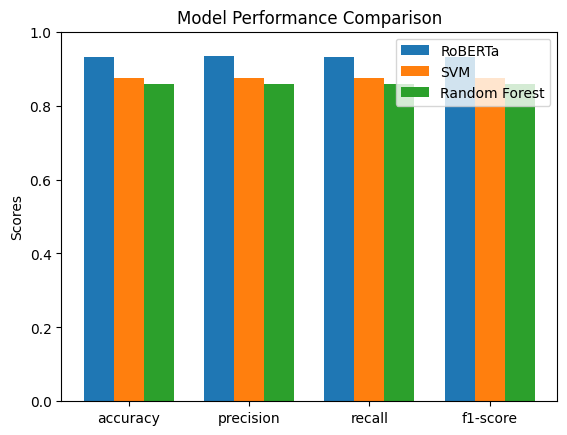

In [26]:
# 24. Plot comparison graph
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
roberta_scores = [roberta_eval_results[m] for m in metrics]
svm_scores = [svm_eval_results[m] for m in metrics]
rf_scores = [rf_eval_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, roberta_scores, width, label='RoBERTa')
rects2 = ax.bar(x, svm_scores, width, label='SVM')
rects3 = ax.bar(x + width, rf_scores, width, label='Random Forest')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.ylim(0, 1)
plt.show()

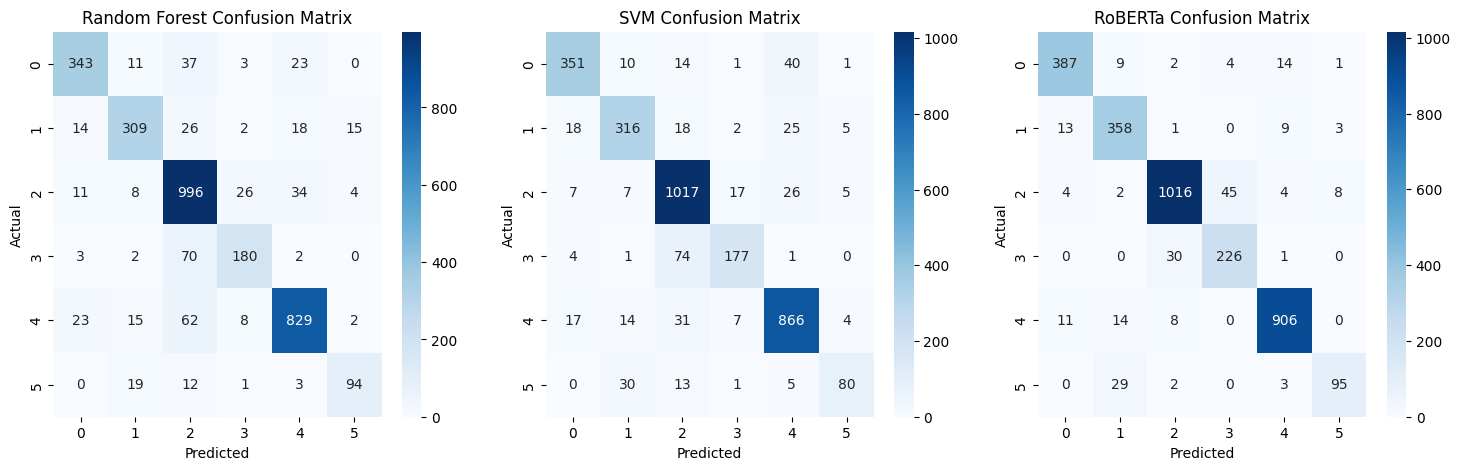

In [27]:
# 25. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = ['Random Forest', 'SVM', 'RoBERTa']
preds = [y_pred_rf, y_pred_svm, y_pred_roberta]
for i, (model, y_pred) in enumerate(zip(models, preds)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.show()

In [28]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.4 MB/s eta 0:00:00


In [29]:
! wget -q -O - ipv4.icanhazip.com

35.197.26.28


In [30]:
%%writefile app.py
import streamlit as st
from transformers import RobertaTokenizer, RobertaForSequenceClassification, pipeline
import os
import joblib
import torch

# Ensure the model is correctly located (Colab path handling)
model_path = "/content/saved_model"  # Adjust this if the model is in another directory

# Streamlit UI
st.title("Sentiment Classification Using RoBERTa")
st.write("Enter a text below, and the app will predict its sentiment.")

if not os.path.exists(model_path):
    st.error("Model directory not found! Ensure you have trained and saved the model.")
else:
    try:
        # Load model and tokenizer
        model = RobertaForSequenceClassification.from_pretrained(model_path)
        tokenizer = RobertaTokenizer.from_pretrained(model_path)

        # Load LabelEncoder to decode sentiment labels
        label_encoder_path = os.path.join(model_path, "label_encoder.pkl")
        if os.path.exists(label_encoder_path):
            label_encoder = joblib.load(label_encoder_path)
        else:
            st.error("Label encoder not found!")
            label_encoder = None  # Prevent crash if missing

        # Create sentiment analysis pipeline (ensuring GPU is used if available)
        device = 0 if torch.cuda.is_available() else -1  # Use GPU if available
        predictor = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

        # Text input
        text_input = st.text_area("Enter text:", "")

        if st.button("Analyze"):
            if text_input.strip():
                result = predictor(text_input)
                predicted_label = result[0]['label']
                confidence = result[0]['score']

                # Convert "LABEL_X" to actual sentiment if label_encoder is loaded
                if label_encoder:
                    label_index = int(predicted_label.split('_')[-1])
                    decoded_label = label_encoder.inverse_transform([label_index])[0]
                    st.success(f"**Prediction:** {decoded_label}")
                else:
                    st.success(f"**Prediction (Raw):** {predicted_label}")

                st.write(f"**Confidence:** {confidence:.4f}")

            else:
                st.warning("Please enter some text.")

    except Exception as e:
        st.error(f"Error loading model: {str(e)}")

Writing app.py


In [33]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.26.28:8501

your url is: https://breezy-points-notice.loca.lt
  Stopping...
^C
